# Payments Dataset EDA

This notebook explores the synthetic payments dataset generated in Stage 1.

Objectives:
- Understand schema, distributions, and seasonality
- Examine merchant, country, and device patterns
- Inspect fraud labels vs amount and time-of-day
- Produce summary tables for downstream analytics


In [58]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('talk')

# Paths
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
DATA_PATH = os.path.join(PROJECT_ROOT, 'data', 'payments.csv')

# Load
df = pd.read_csv(DATA_PATH, parse_dates=['timestamp'])
print(f"Rows: {len(df):,} | Columns: {len(df.columns)}")

# Ensure v2 columns exist (if not, compute or add defaults)
if 'segment' not in df.columns:
    df['segment'] = 'consumer'
if 'is_refunded' not in df.columns:
    df['is_refunded'] = df['amount'] < 50.0

df.head()


Rows: 10,000 | Columns: 11


,transaction_id,user_id,segment,country,merchant,category,amount,timestamp,device_type,is_refunded,is_fraudulent
0,879463009885,208,SMB,AR,Microsoft,electronics,126.02,2023-01-01 01:04:39+00:00,tablet,False,False
1,404737561214,183,consumer,US,Telcel,telco,48.31,2023-01-01 03:08:19+00:00,tablet,False,False
2,12503321040,155,consumer,BR,Oxxo,retail,10.56,2023-01-01 08:52:04+00:00,mobile,False,False
3,176693838346,89,consumer,CL,Amazon,e-commerce,43.70,2023-01-01 11:25:07+00:00,desktop,False,False
4,276091832029,921,merchant,MX,Airbnb,travel,139.69,2023-01-01 12:43:28+00:00,mobile,False,False


In [59]:
# Overview & schema
print(df.dtypes)
print()
print("Missing values per column:\n", df.isna().sum())

# Basic checks for v2
required_cols = ['transaction_id','user_id','segment','country','merchant','category','amount','timestamp','device_type','is_refunded','is_fraudulent']
missing = [c for c in required_cols if c not in df.columns]
if missing:
    print('Missing expected columns:', missing)

summary = df.describe(include='all')
summary


transaction_id                  int64
user_id                         int64
segment                        object
country                        object
merchant                       object
category                       object
amount                        float64
timestamp         datetime64[ns, UTC]
device_type                    object
is_refunded                      bool
is_fraudulent                    bool
dtype: object

Missing values per column:
 transaction_id    0
user_id           0
segment           0
country           0
merchant          0
category          0
amount            0
timestamp         0
device_type       0
is_refunded       0
is_fraudulent     0
dtype: int64


,transaction_id,user_id,segment,country,merchant,category,amount,timestamp,device_type,is_refunded,is_fraudulent
count,1.000000e+04,10000.000000,10000,10000,10000,10000,10000.000000,10000,10000,10000,10000
unique,NaN,NaN,3,5,23,12,NaN,NaN,3,2,2
top,NaN,NaN,consumer,US,Amazon,e-commerce,NaN,NaN,mobile,False,False
freq,NaN,NaN,7992,5991,851,2517,NaN,NaN,6487,9612,9987
mean,4.995129e+11,486.577500,NaN,NaN,NaN,NaN,46.653117,2024-05-30 07:54:34.580599808+00:00,NaN,NaN,NaN
min,1.264838e+09,1.000000,NaN,NaN,NaN,NaN,0.700000,2023-01-01 01:04:39+00:00,NaN,NaN,NaN
25%,2.494721e+11,228.000000,NaN,NaN,NaN,NaN,10.860000,2023-09-19 20:27:07.750000128+00:00,NaN,NaN,NaN
50%,4.990645e+11,489.000000,NaN,NaN,NaN,NaN,21.745000,2024-05-26 20:38:21+00:00,NaN,NaN,NaN
75%,7.490994e+11,720.000000,NaN,NaN,NaN,NaN,48.500000,2025-02-08 22:59:05+00:00,NaN,NaN,NaN
max,9.999537e+11,1000.000000,NaN,NaN,NaN,NaN,1346.090000,2025-10-27 22:19:06+00:00,NaN,NaN,NaN


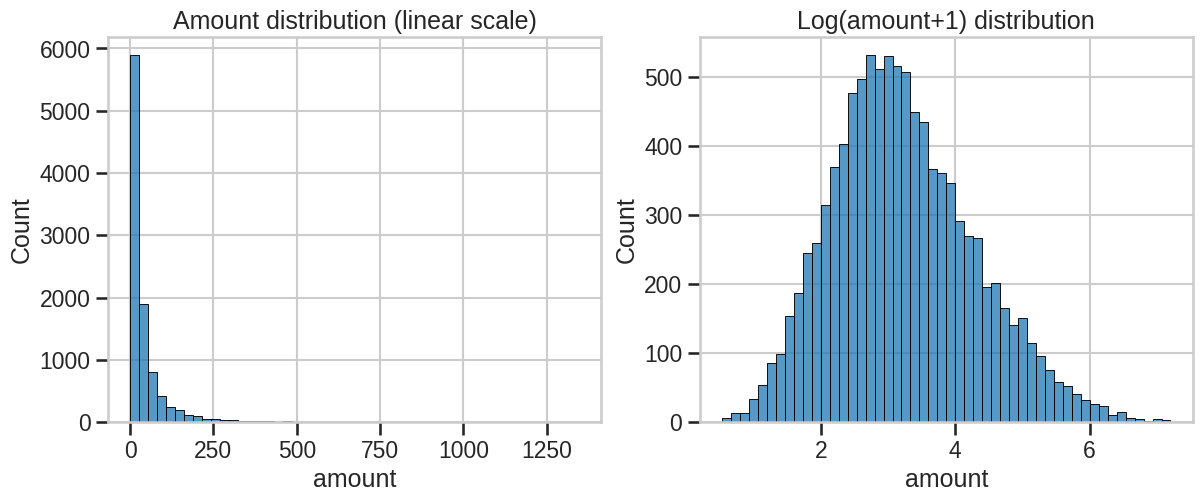

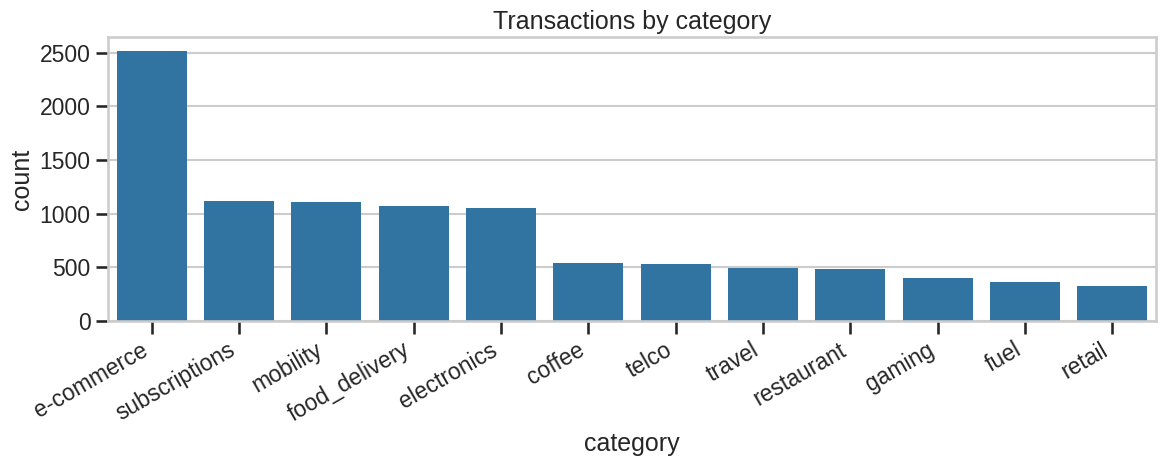

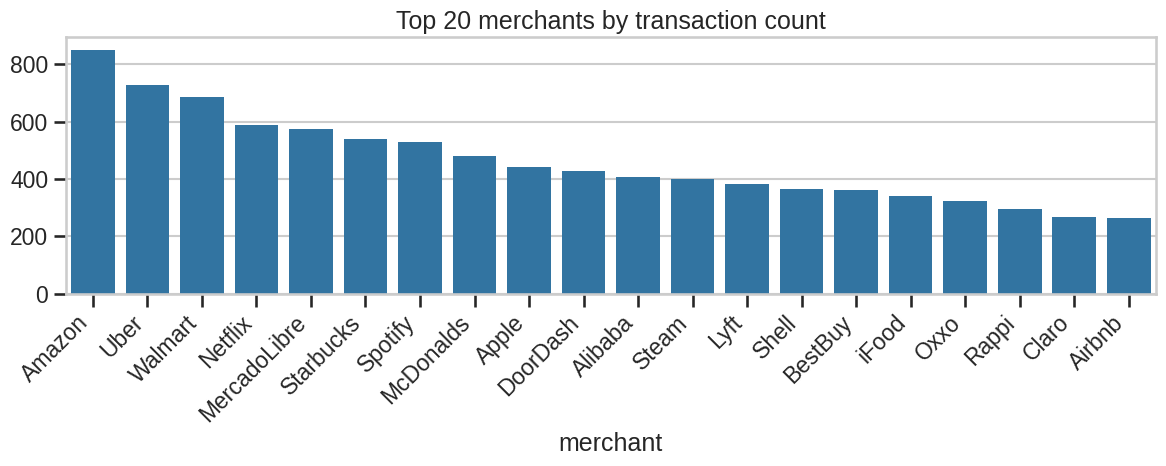

In [60]:
# Distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df['amount'], bins=50, ax=axes[0])
axes[0].set_title('Amount distribution (linear scale)')

sns.histplot(np.log1p(df['amount']), bins=50, ax=axes[1])
axes[1].set_title('Log(amount+1) distribution')
plt.show()

# Category share
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='category', order=df['category'].value_counts().index)
plt.xticks(rotation=30, ha='right')
plt.title('Transactions by category')
plt.tight_layout()
plt.show()

# Merchant frequency (top 20)
plt.figure(figsize=(12, 5))
top_merchants = df['merchant'].value_counts().head(20)
sns.barplot(x=top_merchants.index, y=top_merchants.values)
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 merchants by transaction count')
plt.tight_layout()
plt.show()


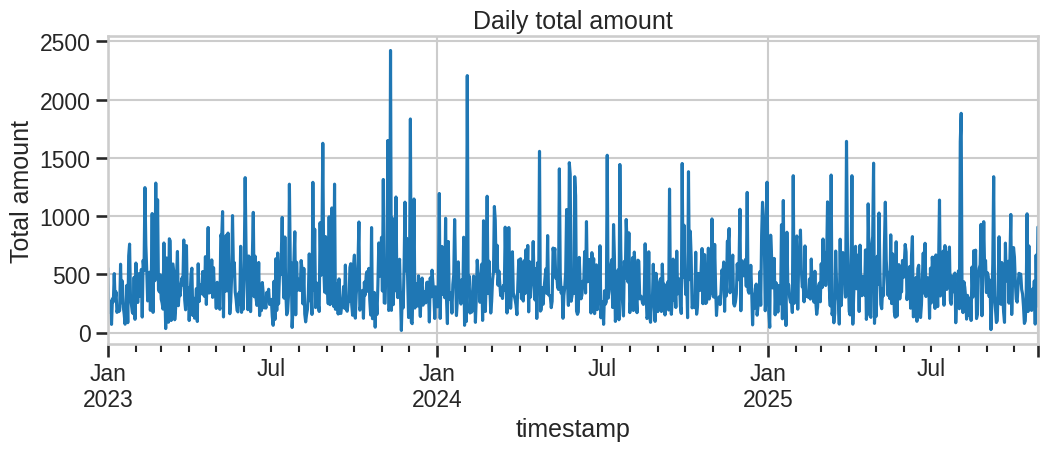

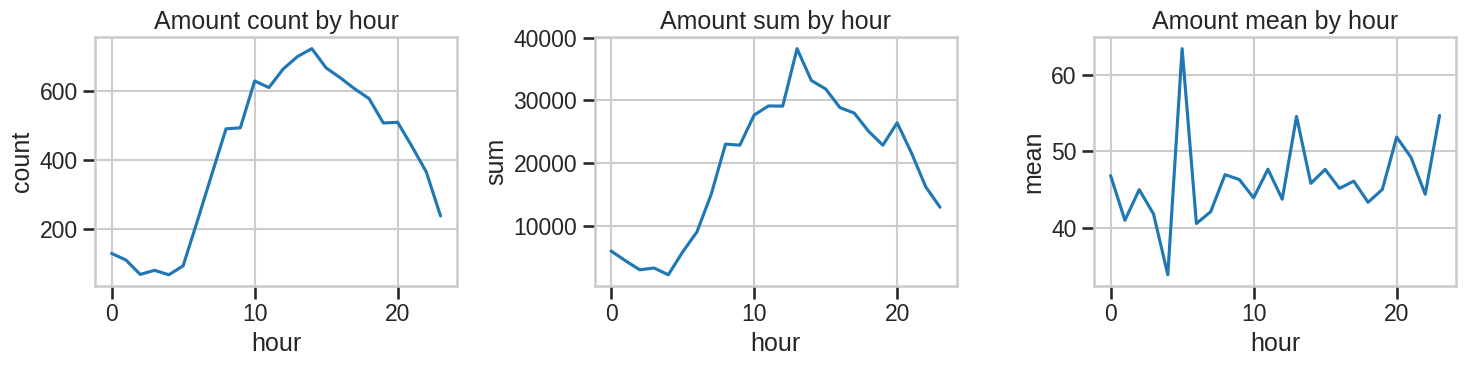

In [61]:
# Time series views
s = df.set_index('timestamp').sort_index()

# By day
by_day = s['amount'].resample('D').sum()
ax = by_day.plot(figsize=(12,4), title='Daily total amount')
ax.set_ylabel('Total amount')
plt.show()

# By hour of day
s['hour'] = s.index.hour
hourly = s.groupby('hour')['amount'].agg(['count','sum','mean'])
fig, axes = plt.subplots(1, 3, figsize=(15,4))
for ax, col in zip(axes, ['count','sum','mean']):
    sns.lineplot(x=hourly.index, y=hourly[col], ax=ax)
    ax.set_title(f'Amount {col} by hour')
plt.tight_layout()
plt.show()


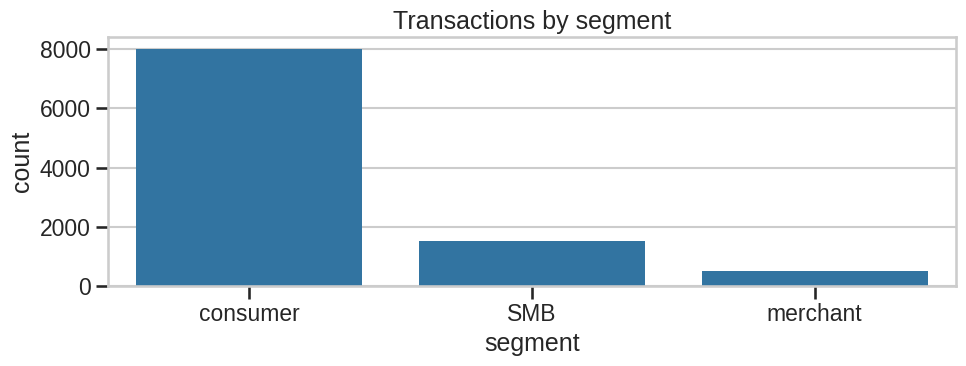

,tx_count,avg_amount,refund_rate,fraud_rate
segment,,,,
consumer,7992,46.448,0.038,0.001
SMB,1515,46.513,0.042,0.003
merchant,493,50.417,0.039,0.000


In [62]:
# Segment analysis
plt.figure(figsize=(10,4))
sns.countplot(data=df, x='segment', order=df['segment'].value_counts().index)
plt.title('Transactions by segment')
plt.tight_layout()
plt.show()

seg_stats = df.groupby('segment').agg(
    tx_count=('transaction_id','count'),
    avg_amount=('amount','mean'),
    refund_rate=('is_refunded','mean'),
    fraud_rate=('is_fraudulent','mean'),
).sort_values('tx_count', ascending=False)
seg_stats.round(3)


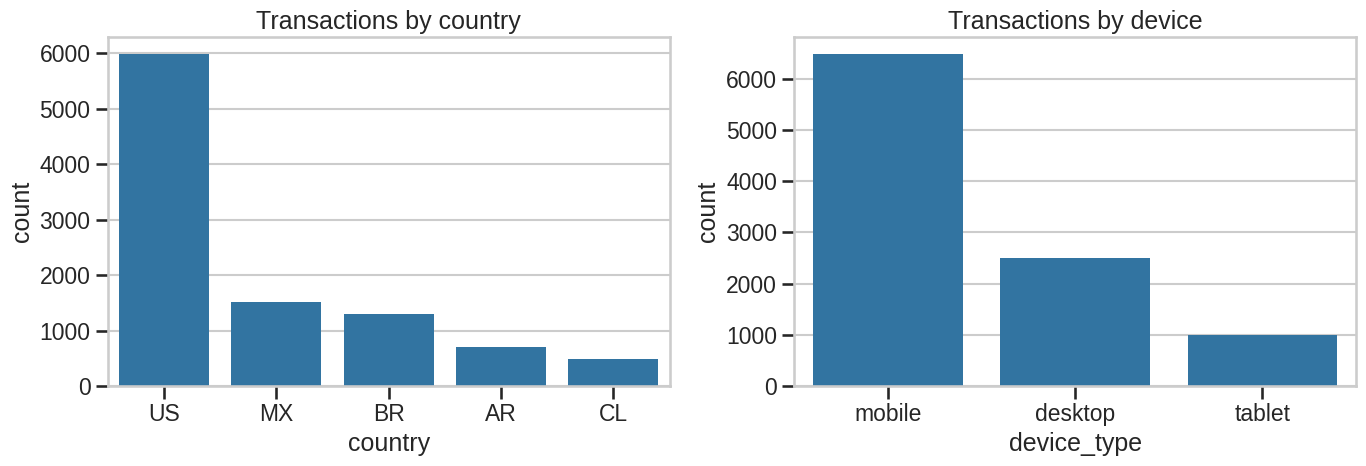

device_type  desktop  mobile  tablet
country                             
AR             46.58   40.59   40.39
BR             42.64   47.93   45.77
CL             41.45   43.23   27.81
MX             38.58   38.73   33.02
US             51.44   48.77   52.66


In [63]:
# Country and device analysis
fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.countplot(data=df, x='country', order=df['country'].value_counts().index, ax=axes[0])
axes[0].set_title('Transactions by country')

sns.countplot(data=df, x='device_type', order=df['device_type'].value_counts().index, ax=axes[1])
axes[1].set_title('Transactions by device')
plt.tight_layout()
plt.show()

# Spend per country/device
pivot = df.pivot_table(index='country', columns='device_type', values='amount', aggfunc='mean')
print(pivot.round(2))


Overall fraud rate: 0.130% | Refund rate: 3.880%


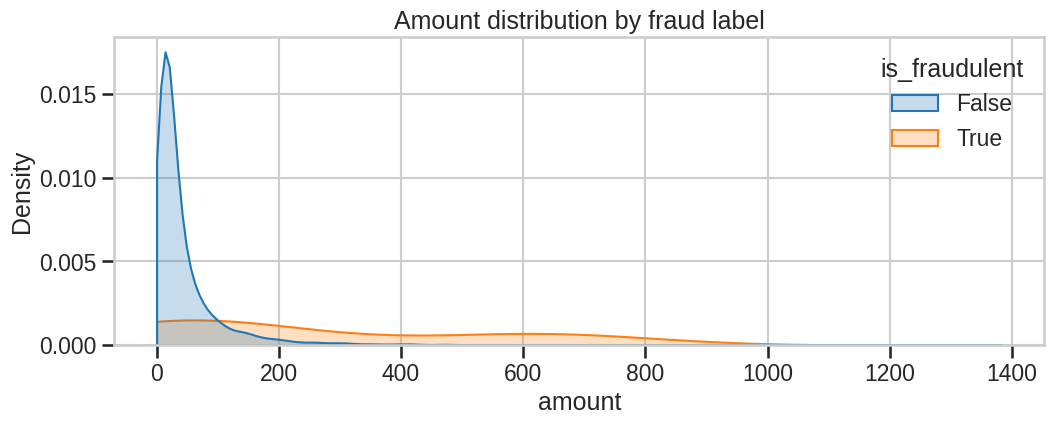

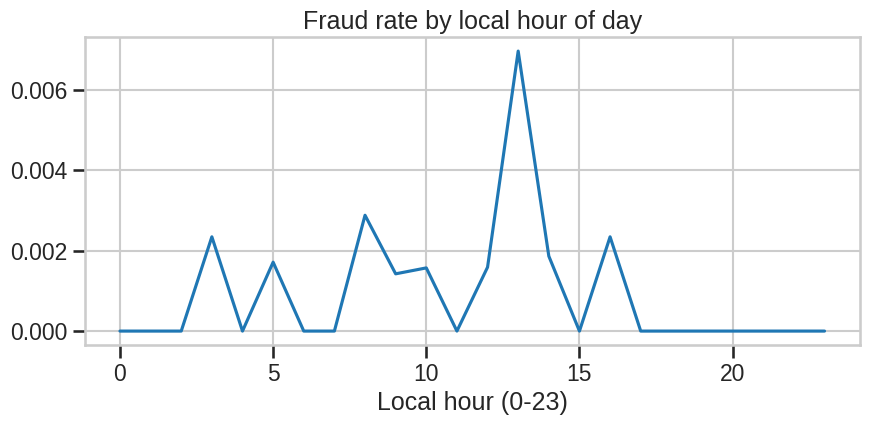

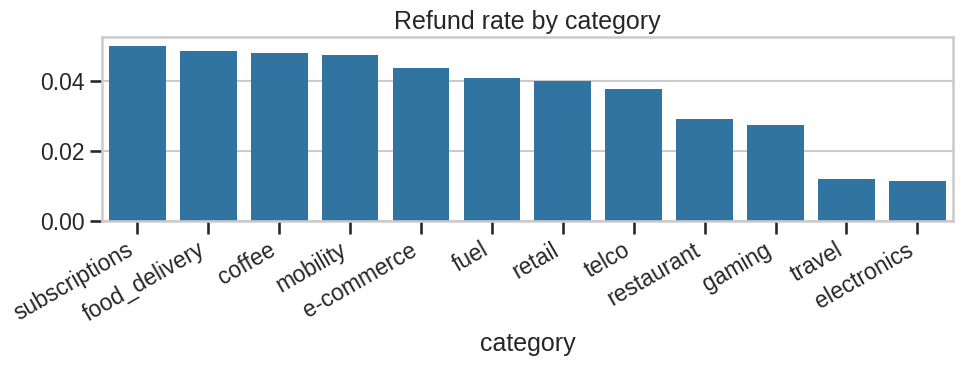

In [64]:
# Fraud and refunds analysis
fraud_rate = df['is_fraudulent'].mean()
refund_rate = df['is_refunded'].mean() if 'is_refunded' in df.columns else float('nan')
print(f"Overall fraud rate: {fraud_rate:.3%} | Refund rate: {refund_rate:.3%}")

# Amount vs fraud
plt.figure(figsize=(12,4))
sns.kdeplot(data=df, x='amount', hue='is_fraudulent', common_norm=False, fill=True, clip=(0, None))
plt.title('Amount distribution by fraud label')
plt.show()

# Hour vs fraud (local time per country)
# Approximate country UTC offsets consistent with generator
offsets = {
    'US': -5,
    'MX': -6,
    'AR': -3,
    'BR': -3,
    'CL': -4,
}
local_hour = (df['timestamp'].dt.hour + df['country'].map(offsets)).mod(24)
fraud_by_local_hour = df.assign(local_hour=local_hour).groupby('local_hour')['is_fraudulent'].mean()
plt.figure(figsize=(10,4))
sns.lineplot(x=fraud_by_local_hour.index, y=fraud_by_local_hour.values)
plt.title('Fraud rate by local hour of day')
plt.xlabel('Local hour (0-23)')
plt.show()

# Refunds by category
if 'is_refunded' in df.columns:
    by_cat = df.groupby('category')['is_refunded'].mean().sort_values(ascending=False)
    plt.figure(figsize=(10,4))
    sns.barplot(x=by_cat.index, y=by_cat.values)
    plt.xticks(rotation=30, ha='right')
    plt.title('Refund rate by category')
    plt.tight_layout()
    plt.show()


<Axes: xlabel='amount', ylabel='Density'>

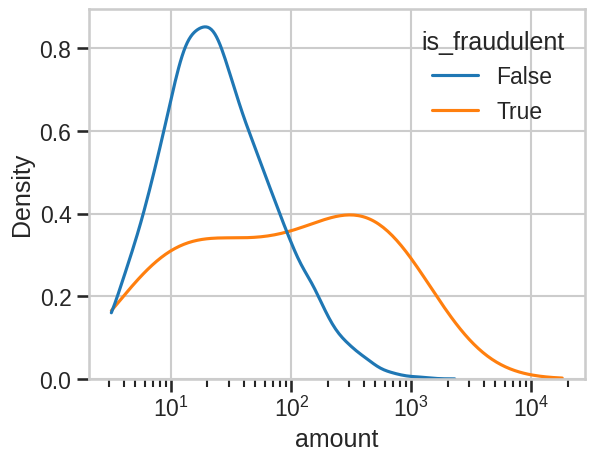

In [65]:
sns.kdeplot(data=df, x="amount", hue="is_fraudulent",
            common_norm=False, log_scale=True, clip=(0.5, None))


<Axes: xlabel='amount', ylabel='Density'>

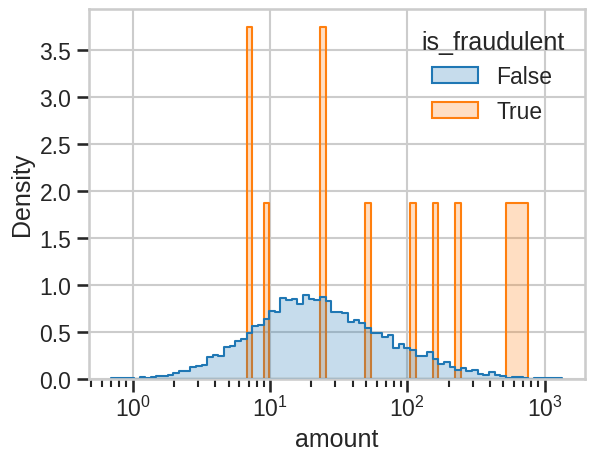

In [66]:
sns.histplot(data=df, x="amount", hue="is_fraudulent",
             bins=80, element="step", stat="density", common_norm=False, log_scale=True)


<Axes: xlabel='amount', ylabel='Density'>

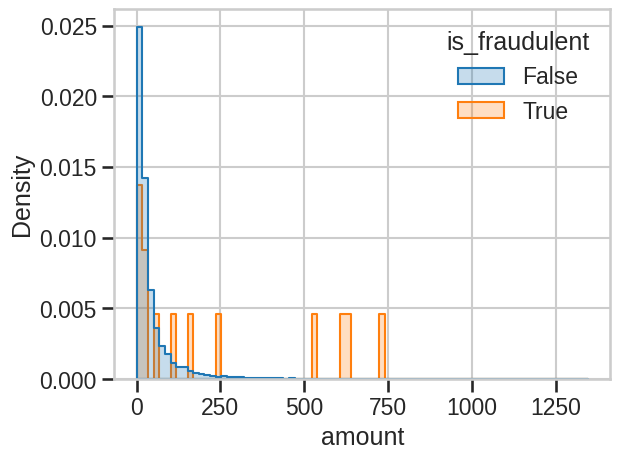

In [67]:
sns.histplot(data=df, x="amount", hue="is_fraudulent",
             bins=80, element="step", stat="density", common_norm=False)


<Axes: xlabel='amount', ylabel='Density'>

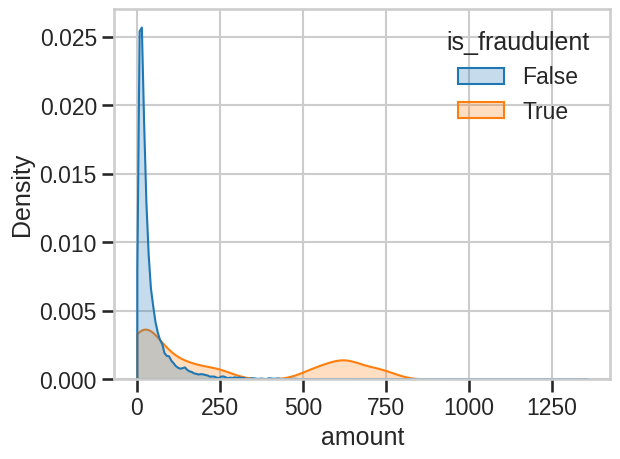

In [68]:
sns.kdeplot(data=df, x='amount', hue='is_fraudulent', common_norm=False, fill=True, bw_adjust=0.3, clip=(0, None))

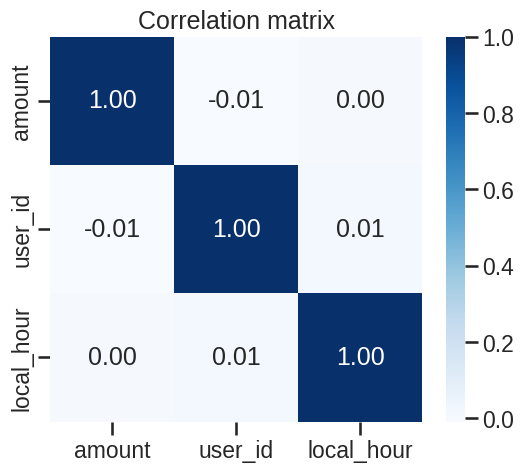

,tx_count,total_amount,avg_amount,refund_rate,fraud_rate
merchant,,,,,
Amazon,851,28881.65,33.94,0.0376,0.0012
Uber,728,12742.69,17.50,0.0563,0.0000
Walmart,686,24177.42,35.24,0.0379,0.0000
Netflix,588,6618.59,11.26,0.0374,0.0000
MercadoLibre,574,19230.28,33.50,0.0557,0.0000
Starbucks,541,4456.17,8.24,0.0481,0.0000
Spotify,530,6425.07,12.12,0.0642,0.0000
McDonalds,480,10589.95,22.06,0.0292,0.0021
Apple,441,75567.62,171.36,0.0091,0.0068


In [71]:
df['local_hour'] = (df['timestamp'].dt.hour + df['country'].map(offsets)).mod(24)

# Correlations
numeric_cols = ['amount', 'user_id', 'local_hour']

corr = df[numeric_cols].corr(numeric_only=True)
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues')
plt.title('Correlation matrix')
plt.show()

# Merchant performance table
merchant_stats = (
    df.groupby('merchant')
      .agg(tx_count=('transaction_id','count'),
           total_amount=('amount','sum'),
           avg_amount=('amount','mean'),
           refund_rate=('is_refunded','mean'),
           fraud_rate=('is_fraudulent','mean'))
      .sort_values('tx_count', ascending=False)
      .head(20)
)
merchant_stats.round({'total_amount': 2, 'avg_amount': 2, 'refund_rate': 4, 'fraud_rate': 4})
